In [ ]:
import pypsa
import pandas as pd
import geopandas as gpd



In [ ]:
import sys
sys.path.append("../processed_spatial_res")

from get_spatial_res import get_spatial_res

regions = get_spatial_res()
print(regions)

In [177]:
import importlib
import cutout_local
importlib.reload(cutout_local)


import get_existing_conv_pp
importlib.reload(get_existing_conv_pp)

<module 'get_existing_conv_pp' from '/Users/simon/DSESM/data/pypsa_model/../processed_existing_conv_pp/get_existing_conv_pp.py'>

In [ ]:
sys.path.append("../processed_existing_conv_pp")
from get_existing_conv_pp import (get_existing_conv_pp)

In [ ]:
gdf_pp = get_existing_conv_pp()



,primary_fuel,capacity_mw,geometry
822,Hydro,168.0,POINT (14.4305 48.248)
823,Hydro,26.0,POINT (15.55 46.7667)
824,Hydro,30.0,POINT (15.1667 47.0167)
825,Hydro,287.0,POINT (14.023 48.3853)
826,Hydro,16.0,POINT (13.2205 47.407)
827,Hydro,100.0,POINT (13.006 48.244)
828,Hydro,16.0,POINT (15.2833 47.4167)
829,Gas,395.0,POINT (16.4633 48.2)
830,Hydro,72.0,POINT (13.16 48.2194)
831,Hydro,1.0,POINT (14.7333 47.6)


In [180]:
regions_3035 = regions.to_crs(3035)
pp_3035 = gdf_pp.to_crs(3035)



Index(['primary_fuel', 'capacity_mw', 'geometry', 'region_5', 'region'], dtype='object')

In [ ]:
pp_with_region["region"] = pp_with_region["region_5"]


,primary_fuel,capacity_mw,region
822,Hydro,168.0,Oberösterreich/Salzburg
823,Hydro,26.0,Kärnten/Steiermark
824,Hydro,30.0,Kärnten/Steiermark
825,Hydro,287.0,Oberösterreich/Salzburg
826,Hydro,16.0,Oberösterreich/Salzburg
827,Hydro,100.0,Oberösterreich/Salzburg
828,Hydro,16.0,Kärnten/Steiermark
829,Gas,395.0,Wien
830,Hydro,72.0,Oberösterreich/Salzburg
831,Hydro,1.0,Kärnten/Steiermark


In [211]:
conv_cap = (
    pp_with_region
    .groupby(["region", "primary_fuel"])["capacity_mw"]
    .sum()
)
conv_cap = conv_cap.loc[
    conv_cap.index.get_level_values("primary_fuel")
    .isin(["Gas", "Hydro"])
]
conv_cap

region                       primary_fuel
Kärnten/Steiermark           Hydro           1742.0
Niederösterreich/Burgenland  Hydro            716.0
Oberösterreich/Salzburg      Gas              400.0
                             Hydro           2389.0
Tirol/Vorarlberg             Hydro           3563.0
Wien                         Gas             1667.0
                             Hydro            358.0
Name: capacity_mw, dtype: float64

Index(['Hydro', 'Gas'], dtype='object', name='primary_fuel')

In [213]:
for c in ["gas", "hydro"]:
    if c not in n.carriers.index:
        n.add("Carrier", c)


In [214]:
for (region, fuel), cap in conv_cap.items():
    if fuel != "Gas":
        continue

    n.add(
        "Generator",
        name=f"gas_existing_{region}",
        bus=region,
        carrier="gas",
        p_nom=cap,
        p_nom_extendable=False,
        efficiency=0.5, #default
        marginal_cost=80.0 #default
    )


In [ ]:
for (region, fuel), cap in conv_cap.items():
    if fuel != "Hydro":
        continue

    n.add(
        "Generator",
        name=f"hydro_existing_{region}",
        bus=region,
        carrier="hydro",
        p_nom=cavp,
        p_nom_extendable=False,
        p_max_pu=0.45, #default
        marginal_cost=5.0 #default 
    )


In [129]:
sys.path.append("../processed_capacity_factors")
from cutout_local import (
    get_cutout,
    get_availability,
    get_pv_and_wind,
    get_excluders
)


In [130]:
excluder_solar, excluder_wind = get_excluders()


In [131]:
# 4) Availability-Matrizen
A_pv, A_w = get_availability(
    cutout=cutout,
    regions=regions,
    excluder_solar=excluder_solar,
    excluder_wind=excluder_wind
)


In [141]:
# 5) PV & Wind Potenziale + CFs
pv_cap, pv_cf, wind_cap, wind_cf = get_pv_and_wind(
    cutout=cutout,
    regions=regions,
    A_pv=A_pv,
    A_w=A_w
)
pv_cf_df = pv_cf.to_pandas()


INFO:atlite.convert:Convert and aggregate 'pv'.
/opt/miniconda3/envs/global_py/lib/python3.11/site-packages/atlite/resource.py:90: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.

INFO:atlite.convert:Convert and aggregate 'wind'.


In [143]:
n=pypsa.Network()
regions=get_spatial_res()
regions



,geometry,GID_0,COUNTRY,NAME_1,REP_POINT
region_5,,,,,
Kärnten/Steiermark,"POLYGON ((14.43537 46.44343, 14.43537 46.44345...",AUT,Austria,Kärnten,POINT (14.98609 47.10053)
Niederösterreich/Burgenland,"POLYGON ((16.06715 46.84889, 16.0672 46.84884,...",AUT,Austria,Burgenland,POINT (15.92138 47.92607)
Oberösterreich/Salzburg,"POLYGON ((13.69947 47.00479, 13.69858 47.00534...",AUT,Austria,Oberösterreich,POINT (13.86111 47.85873)
Tirol/Vorarlberg,"MULTIPOLYGON (((12.39612 46.71143, 12.39598 46...",AUT,Austria,Tirol,POINT (10.82959 47.25349)
Wien,"POLYGON ((16.29905 48.12999, 16.29897 48.12999...",AUT,Austria,Wien,POINT (16.37248 48.2208)


In [144]:
for region, row in regions.iterrows():
    n.add("Bus",name=region,x=row["REP_POINT"].x,y=row["REP_POINT"].y,carrier="electricity")

n.buses #check


,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
name,,,,,,,,,,,,,
Kärnten/Steiermark,1.0,,14.986091,47.100529,electricity,,,1.0,0.0,inf,PQ,,
Niederösterreich/Burgenland,1.0,,15.921376,47.926071,electricity,,,1.0,0.0,inf,PQ,,
Oberösterreich/Salzburg,1.0,,13.861108,47.858727,electricity,,,1.0,0.0,inf,PQ,,
Tirol/Vorarlberg,1.0,,10.829591,47.253490,electricity,,,1.0,0.0,inf,PQ,,
Wien,1.0,,16.372481,48.220801,electricity,,,1.0,0.0,inf,PQ,,


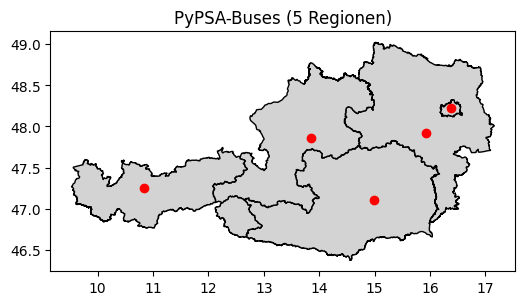

In [145]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
regions.plot(ax=ax, color="lightgrey", edgecolor="black")
ax.scatter(n.buses.x, n.buses.y, color="red", zorder=5)
ax.set_title("PyPSA-Buses (5 Regionen)")
plt.show()



In [146]:
n.set_snapshots(pv_cf_df.index)


In [147]:
dummy_load = pd.Series(100.0,index=n.snapshots)
for region in regions.index:
    n.add("Load",name=f"load_{region}",bus=region,p_set=dummy_load)

n.loads
n.loads_t.p_set.head()


name,load_Kärnten/Steiermark,load_Niederösterreich/Burgenland,load_Oberösterreich/Salzburg,load_Tirol/Vorarlberg,load_Wien
snapshot,,,,,
2019-01-01 00:00:00,100.0,100.0,100.0,100.0,100.0
2019-01-01 01:00:00,100.0,100.0,100.0,100.0,100.0
2019-01-01 02:00:00,100.0,100.0,100.0,100.0,100.0
2019-01-01 03:00:00,100.0,100.0,100.0,100.0,100.0
2019-01-01 04:00:00,100.0,100.0,100.0,100.0,100.0


In [148]:
pv_cf_df = pv_cf.to_pandas()
pv_cap_s = pv_cap.to_pandas()
for region in regions.index:
    n.add(
        "Generator",
        name=f"PV_{region}",
        bus=region,
        carrier="solar",
        p_nom_extendable=True,
        p_nom_max=pv_cap_s.loc[region],
        p_max_pu=pv_cf_df[region],
        marginal_cost=0.0,
        capital_cost=1.0
    )



In [149]:
wind_cf_df = wind_cf.to_pandas()
wind_cap_s = wind_cap.to_pandas()

for region in regions.index:
    n.add(
        "Generator",
        name=f"Wind_{region}",
        bus=region,
        carrier="wind",
        p_nom_extendable=True,
        p_nom_max=wind_cap_s.loc[region],
        p_max_pu=wind_cf_df[region],
        marginal_cost=0.0,
        capital_cost=1.0
    )


In [150]:
n.generators.head()
n.generators_t.p_max_pu.head()


name,PV_Kärnten/Steiermark,PV_Niederösterreich/Burgenland,PV_Oberösterreich/Salzburg,PV_Tirol/Vorarlberg,PV_Wien,Wind_Kärnten/Steiermark,Wind_Niederösterreich/Burgenland,Wind_Oberösterreich/Salzburg,Wind_Tirol/Vorarlberg,Wind_Wien
snapshot,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.002235,0.035171,0.023880,0.001549,0.041266
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.001939,0.040640,0.027924,0.000982,0.011601
2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.002355,0.055449,0.038919,0.000704,0.008501
2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.002795,0.070147,0.049681,0.000455,0.015222
2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.003294,0.102343,0.059315,0.000341,0.043027


carrier
solar    178325.562777
wind      10458.191501
Name: p_nom_max, dtype: float64

In [217]:
neighbours = [
    ("Wien", "Niederösterreich/Burgenland"),
    ("Niederösterreich/Burgenland", "Oberösterreich/Salzburg"),
    ("Oberösterreich/Salzburg", "Tirol/Vorarlberg"),
    ("Oberösterreich/Salzburg", "Kärnten/Steiermark"),
]

rep_points = regions["REP_POINT"].to_crs(3035)
def distance_km(r1, r2):
    d = rep_points.loc[r1].distance(rep_points.loc[r2])
    return 1.5 * d / 1000  


In [218]:
COST_PER_MW_KM = 700  
for r1, r2 in neighbours:
    length_km = distance_km(r1, r2)
    capital_cost = COST_PER_MW_KM * length_km

    n.add(
        "Link",
        name=f"line_{r1}_{r2}",
        bus0=r1,
        bus1=r2,
        p_nom_extendable=True,
        p_min_pu=-1,      # bidirektional
        p_max_pu=1,
        efficiency=1.0,   # keine Verluste
        capital_cost=capital_cost
    )


In [221]:
n.links.capital_cost


name
line_Wien_Niederösterreich/Burgenland                        49348.813700
line_Niederösterreich/Burgenland_Oberösterreich/Salzburg    162009.844439
line_Oberösterreich/Salzburg_Tirol/Vorarlberg               249935.939944
line_Oberösterreich/Salzburg_Kärnten/Steiermark             125426.296831
Name: capital_cost, dtype: float64